# Genre song classification
In out database we have spectrograms and chomagrams from different song genres: Alternative, Classical, Dance, Pop, Rock and Techno

### Import needed libraries

In [82]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
# Append the directory to your python path using sys
sys.path.append('/content/gdrive/MyDrive/dataset/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [99]:
# Import general purpose python libraries
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
from tensorflow import keras

# Import different Keras functionalities
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Add, Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.constraints import MaxNorm
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import image_dataset_from_directory
from keras import backend as K
from keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.models import Model
from keras.layers import Input, Dense, LSTM

from keras.models import load_model
import tensorflow as tf
from keras.applications import ResNet50, VGG16

from keras.layers import BatchNormalization

from pathlib import Path

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import regularizers

# Import function to plot the confussion matrix
#import plotcm

ImportError: cannot import name 'regularizers' from 'keras.regularizers' (/usr/local/lib/python3.10/dist-packages/keras/regularizers/__init__.py)

### Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [84]:
# Randomize the initial network weights
random_seed = True

# Paths to where spectrograms of training, testing, and validation images are
database_dir = '/content/gdrive/MyDrive/dataset'
train_dir = '/content/gdrive/MyDrive/dataset/training/spectrogram'
val_dir = '/content/gdrive/MyDrive/dataset/val/spectrogram'
test_dir = '/content/gdrive/MyDrive/dataset/test/spectrogram'

# Directory where to store weights of the model and results
experiment_rootdir = "results/"
# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

version = 'VGG16_20_1e-3'
weights_path = f"weights_{version}.h5" # Name of the file to store the weights
weights_file = Path(weights_path)

# Output dimension (number of sublects in our problem)
num_classes = 6

# Name of each gesture of the database
CLASSES = ['Alternative', 'Classical', 'Dance', 'Pop', 'Rock', 'Techno']

# Parameters that characterize the images
img_height = 480
img_width = 640
img_channels = 3 # although some images could be rgb, we work with grayscale images
color_mode = 'rgb'

print(train_dir)

/content/gdrive/MyDrive/dataset/training/spectrogram


## Configuration of parameters and train, val and test datasets

In [85]:
# Parameters that configures the training process
batch_size = 20 # Batch size
epochs = 20 # Number of epochs. Set to 20 for this work
initial_lr = 1e-3 # Learning rate

# 1. Generate train dataset (ds) from directory of samples
train_ds = image_dataset_from_directory(directory=train_dir,
                                        label_mode = 'categorical',
                                        class_names=CLASSES,
                                        batch_size=batch_size,
                                        color_mode=color_mode,
                                        image_size=(img_width,img_height), shuffle=True)

# 2. Generate validation dataset (ds) from directory of samples
val_ds  = image_dataset_from_directory(directory=val_dir,
                                       label_mode = 'categorical',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_width,img_height))

# 3. Generate test dataset (ds) from directory of samples
test_ds = image_dataset_from_directory(directory=test_dir,
                                       label_mode = 'categorical',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_width,img_height),
                                       shuffle = False)

Found 1186 files belonging to 6 classes.
Found 204 files belonging to 6 classes.
Found 213 files belonging to 6 classes.


## Function def for plots

In [86]:
def plot_accuracy_loss(history):
    # 1. Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])  # Use 'accuracy' instead of 'categorical_accuracy'
    plt.plot(history.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_categorical_accuracy'
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # Save the figure
    fig_save_path = os.path.join(experiment_rootdir, f"accuracy_{version}.png")
    plt.savefig(fig_save_path)

    # Show figure
    plt.show()

    # 2. Plot loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig_save_path = os.path.join(experiment_rootdir, f"loss_{version}.png")
    plt.savefig(fig_save_path)
    plt.show()




In [87]:
def plot_confusion_matrix(y_true, predicted_classes):
    cm = confusion_matrix(y_true, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    fig_save_path = os.path.join(experiment_rootdir, f"confussion_matrix_{version}.png")
    plt.savefig(fig_save_path)

    plt.show()

# Training process

# Create many models



## VGG-16

In [88]:

def VGG16(input_shape):
	base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

	# Freeze the pre-trained layers
	for layer in base_model.layers:
			layer.trainable = False



	model = models.Sequential([
			base_model,
			layers.GlobalAveragePooling2D(),
			layers.Dense(512, activation=None),  # No activation here
			layers.BatchNormalization(),
			layers.Activation('relu'),  # Activation after BatchNormalization
			layers.Dropout(0.5),
			layers.Dense(num_classes, activation='softmax')
	])

	return model


"\ndef VGG16(img_width,img_height,img_channels):\n\t#  dropout rate for FC layers\n\tdropout=0.5\n\n\t# CNN architecture\n\tinput_image = Input(shape=(img_width,img_height,img_channels))\n\tx1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)\n\tx1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = MaxPooling2D((2, 2))(x1)\n\tx1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = MaxPooling2D((2, 2))(x1)\n\tx1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = Conv2D(256, (1, 1),padding='same', activation='relu')(x1)\n\tx1 = MaxPooling2D((2, 2))(x1)\n\tx1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)\n\tx1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)\n\tx1 = MaxPooling2D((2, 2))(x1)\n\tx1 = Conv2D

## RestNet

In [89]:

def RestNet (input_shape):
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the pre-trained layers
  for layer in base_model.layers:
      layer.trainable = False



  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(512, activation=None),  # No activation here
      layers.BatchNormalization(),
      layers.Activation('relu'),  # Activation after BatchNormalization
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])

  return model


"\ndef RestNet (img_width,img_height,img_channels):\n  dropout=0.5 # Para evitar que haya overfitting cancela algunas conexiones entre las neuronas aleatoriamente.\n\n  # CNN architecture\n  input_image = Input(shape=(img_width,img_height,img_channels))\n  x0 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)\n  x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x0)\n  x1 = MaxPooling2D((2, 2))(x1)\n  x2 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)\n  x3 = Conv2D(128, (3, 3),padding='same')(x2)\n  x4 = Add()([x3, x2])\n  x4 = Activation('relu')(x4)\n  x4 = MaxPooling2D((2, 2))(x4)\n  x4 = Conv2D(256, (3, 3),padding='same', activation='relu')(x4)\n  x5 = Conv2D(256, (3, 3),padding='same', activation='relu')(x4)\n  x5 = Conv2D(256, (1, 1),padding='same')(x5)\n  x6 = Add()([x5, x4])\n  x6 = Activation('relu')(x6)\n  x6 = MaxPooling2D((2, 2))(x6)\n  x6 = Conv2D(512, (3, 3),padding='same', activation='relu')(x6)\n  x7 = Conv2D(512, (3, 3),padding='same

## CRNN

In [ ]:
def conv_recurrent_model_build(input_shape):
    LSTM_COUNT = 30
    NUM_HIDDEN = 20

    # Load ResNet50 pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Remove the top layers of ResNet50 and add new layers for your CRNN architecture
    layer = base_model.output

    # Flatten output of ResNet50
    layer = Flatten()(layer)

    # LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)

    # Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)

    # Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer

    #model = Model(model_input, model_output)

    opt = Adam(lr=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    print(model.summary())
    return model

In [90]:
# Define the input shape based on your image dimensions
input_shape = (img_width, img_height, img_channels)

model = VGG16(input_shape)
#model = RestNet(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 20, 15, 512)       14714688  
                                                                 
 global_average_pooling2d_6  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 512)               0         
                                                                 
 dropout_6 (Dropout)         (None, 512)              

## Model execution

In [91]:
'''
#Load parameters
if weights_file.is_file():
	model.load_weights(weights_path)

#Model
model = RestNet(img_width,img_height,img_channels)

# Print the architecture of the model
model.summary()
'''

'\n#Load parameters\nif weights_file.is_file():\n\tmodel.load_weights(weights_path)\n\n#Model\nmodel = RestNet(img_width,img_height,img_channels)\n\n# Print the architecture of the model\nmodel.summary()\n'

### Set model training process
Configuration of several training decisions:
1. Optimizer using `Adam`
2. Model training configuration using `compile`. Use a loss and a metric function appropriate for the task
3. Creation of the data generator for the training dataset using `image_dataset_from_directory`
4. Creation of the data generator for the validation dataset using `image_dataset_from_directory`

In [92]:
'''
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)


# 1. Configure optimizer
adam = Adam(learning_rate=initial_lr)

# 2. Configure training process
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])
'''

"\n# Set random seed\nif random_seed:\n    seed = np.random.randint(0,2*31-1)\nelse:\n    seed = 5\nnp.random.seed(seed)\ntf.random.set_seed(seed)\n\n\n# 1. Configure optimizer\nadam = Adam(learning_rate=initial_lr)\n\n# 2. Configure training process\nmodel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])\n"

### Train the model
1. Load parameters from previous trainings if they exist.
2. Fit the model
3. Save the weights

In [93]:
# Load pretrained model
weights_load_path = os.path.join(experiment_rootdir, weights_path)
if weights_load_path:
    try:
        model.load_weights(weights_load_path)
        print("Loaded model from {}".format(weights_load_path))
    except:
        print("Impossible to find weight path. Returning untrained model")

# Fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

# Save weights
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Impossible to find weight path. Returning untrained model
Epoch 1/20
60/60 [==============================] - 50s 784ms/step - loss: 1.9054 - accuracy: 0.3297 - val_loss: 2.1238 - val_accuracy: 0.2696
Epoch 2/20
60/60 [==============================] - 47s 760ms/step - loss: 1.4043 - accuracy: 0.4671 - val_loss: 2.1513 - val_accuracy: 0.3137
Epoch 3/20
60/60 [==============================] - 50s 802ms/step - loss: 1.2392 - accuracy: 0.5126 - val_loss: 2.0680 - val_accuracy: 0.3725
Epoch 4/20
60/60 [==============================] - 50s 810ms/step - loss: 1.0688 - accuracy: 0.5759 - val_loss: 1.8520 - val_accuracy: 0.4167
Epoch 5/20
60/60 [==============================] - 50s 813ms/step - loss: 1.0035 - accuracy: 0.6172 - val_loss: 1.4995 - val_accuracy: 0.4118
Epoch 6/20
60/60 [==============================] - 47s 767ms/step - loss: 0.9054 - accuracy: 0.6560 - val_loss: 1.8646 - val_accuracy: 0.4363
Epoch 7/20
60/60 [==============================] - 48s 774ms/step - loss: 0.8362 - 

### Plot history for accuracy and loss for the training  process

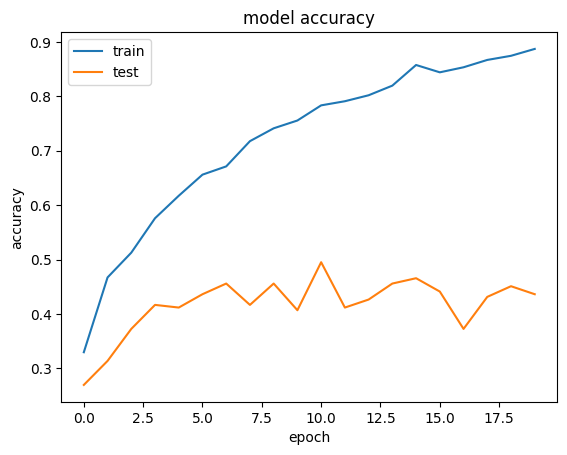

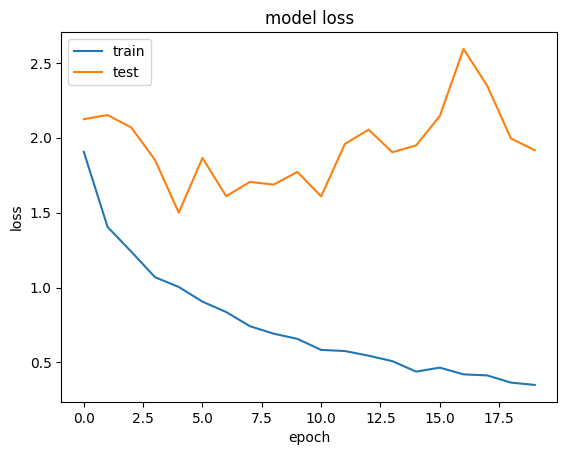

In [94]:
plot_accuracy_loss(history)

# Testing

### Testing process
Compute the loss function and accuracy for the test data (using `evaluate`)

In [95]:
# Evaluate model
scores = model.evaluate(test_ds, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f%%" % scores[0])

Accuracy: 36.62%
Loss: 2.21%


### Generation of the predictions and the confusion matrix for the test data
1.   Compute predictions with `predict`
2.   Select the most probable class with `argmax`

The confusion matrix will be shown with `plotcm`


11/11 [==============================] - 7s 619ms/step


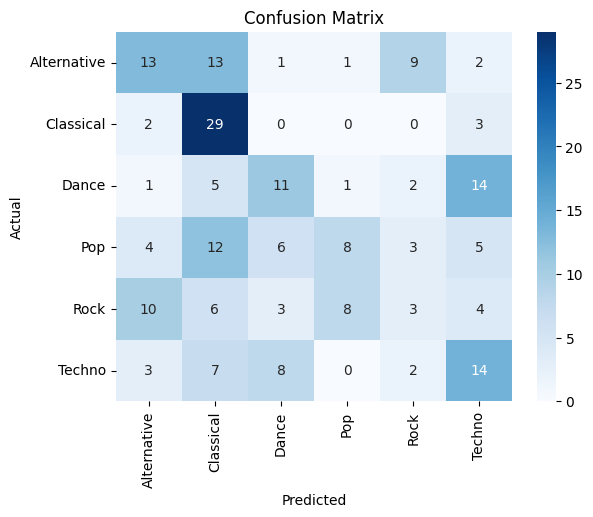

In [96]:

# 1. Get predictions
prob_class = model.predict(test_ds, batch_size=batch_size)

# 2. Prediced labels
y_pred = tf.argmax(prob_class, axis=-1)

# Get ground truth
y_true = tf.argmax(tf.concat([label for image, label in test_ds], axis=0), axis=1)

# Visualize confusion matrix
#plotcm.plotcm(experiment_rootdir, version, y_true, y_pred, CLASSES, experiment_rootdir, normalize=True)
plot_confusion_matrix(y_true, y_pred)
